In [1]:
import numpy as np
import math
import importlib
import sys
import time
import gc
from joblib import Parallel, delayed, parallel_backend

from matplotlib import pyplot as plt

In [2]:
rerun = True

In [3]:
# just setting up logging

import logging
from logging import debug

def config_log():
    FORMAT = "%(message)s"
    LEVEL = logging.ERROR
    STREAM = sys.stdout
    importlib.reload(logging)
    logging.basicConfig(format=FORMAT, level=LEVEL, stream=STREAM)
    
config_log()

# Explicit Triangle Counting

In [4]:
def ExactTriangles(A, gamma=None):
    A3 = A.dot(A.dot(A))
    return math.floor(np.trace(A3) / 6)

# Algorithm 1

In [5]:
# args: adjacency matrix of size n

def TraceTriangleN(A, gamma, parallel = False):
    # line 1
    
    n = A.shape[0]
    debug("n: {0}".format(n))
    
    # line 2
    
    M = math.ceil(gamma * math.pow(math.log(n), 2))
    debug("M: {0}".format(M))
    
    # line 3
    
    if parallel:
        with parallel_backend('threading', n_jobs=8):
            T = Parallel()(delayed(TraceTriangleN_Loop)(A, n) for i in range(M))
    else:
        T = np.zeros(M)
        for i in range(M):
            T[i] = TraceTriangleR_Loop(A, n)
    # line 7
    
    # line 8
    
    Delta = 0
    
    for i in range(M):
        Delta += T[i] / M
        
    return Delta

def TraceTriangleN_Loop(A, n):
    #line 4

    x = np.random.normal(size = n)

    # line 5

    y = A.dot(x)

    # line 6

    return y.T.dot(A.dot(y)) / 6


# Modified  Algorithm 1

In [6]:
# args: adjacency matrix of size n

def TraceTriangleR(A, gamma, parallel=False):
    # line 1
    
    n = A.shape[0]
    debug("n: {0}".format(n))
    
    # line 2
    
    M = math.ceil(gamma * math.pow(math.log(n), 2))
    debug("M: {0}".format(M))
    
    # line 3
    
    if parallel:
        with parallel_backend('threading', n_jobs=8):
            T = Parallel()(delayed(TraceTriangleR_Loop)(A, n) for i in range(M))
    else:
        T = np.zeros(M)
        for i in range(M):
            T[i] = TraceTriangleR_Loop(A, n)
        
    # line 7
    
    # line 8
    
    Delta = 0
    
    for i in range(M):
        Delta += T[i] / M
        
    return Delta

def TraceTriangleR_Loop(A, n):
    #line 4

    x = np.random.choice(np.array([-1, 1]), size=n)

    debug(x)

    # line 5

    y = A.dot(x)

    # line 6

    return y.T.dot(A.dot(y)) / 6

# Evaluation

Each algorithm is evaluated against several datasets

In [7]:
def do_test(method, matrix, rounds, correct=None, gamma=None):
    results = []
    times = []
    
    for _ in range(rounds):
        start = time.time()
        ans = method(matrix, gamma)
        delta = time.time() - start
        times.append(delta)
        results.append(ans)
    
    mean_result = sum(results) / len(results)
    mean_time = sum(times) / len(times)
    
    return method.__name__, times, results

def show_test(name, time, answer):
    print(name)
    print("Time: {0}".format(time))
    print("Answer: {0}".format(answer))

def test_with(matrix, gamma, rounds):
    show_test(*do_test(ExactTriangles, matrix, rounds=1, gamma=gamma))
    show_test(*do_test(TraceTriangleN, matrix, rounds, gamma=gamma))
    show_test(*do_test(TraceTriangleR, matrix, rounds, gamma=gamma))

## 1 triangle

In [8]:
OneTri = np.zeros((3, 3))
i,j = np.indices(OneTri.shape)

OneTri[i==j-2] = 1
OneTri[i==j-1] = 1
OneTri[i==j+1] = 1
OneTri[i==j+2] = 1

## 10x10 penta-diagonal

In [9]:
A10 = np.zeros((10,10))
i,j = np.indices(A10.shape)

A10[i==j-2] = 1
A10[i==j-1] = 1
A10[i==j+1] = 1
A10[i==j+2] = 1

## 100x100 penta-diagonal

In [10]:
A100 = np.zeros((100,100))
i,j = np.indices(A100.shape)

A100[i==j-2] = 1
A100[i==j-1] = 1
A100[i==j+1] = 1
A100[i==j+2] = 1

## 1000x1000 penta-diagonal

In [11]:
A1k = np.zeros((1000,1000))
i,j = np.indices(A1k.shape)

A1k[i==j-2] = 1
A1k[i==j-1] = 1
A1k[i==j+1] = 1
A1k[i==j+2] = 1

## 10000x10000 penta-diagonal

In [12]:
A10k = np.zeros((10000,10000))
i,j = np.indices(A10k.shape)

A10k[i==j-2] = 1
A10k[i==j-1] = 1
A10k[i==j+1] = 1
A10k[i==j+2] = 1

In [13]:
def generate_diag(width):
    matrix = np.zeros((width, width))
    i,j = np.indices(matrix.shape)

    matrix[i==j-2] = 1
    matrix[i==j-1] = 1
    matrix[i==j+1] = 1
    matrix[i==j+2] = 1
    
    return matrix

In [14]:
def generate_random(size, count, invert=False):
    store = 0 if invert else 1
    start = 1 if invert else 0
    matrix = np.zeros((size, size))
    matrix.fill(start)
    for _ in range(count):
        i = np.random.randint(0, size)
        while True:
            j = np.random.randint(0, size)
            if j != i:
                break
        while True:
            k = np.random.randint(0, size)
            if k != i and k != j:
                break

        matrix[i,j] = store
        matrix[j,i] = store
        matrix[i,k] = store
        matrix[k,i] = store
        matrix[j,k] = store
        matrix[k,j] = store
        
    return matrix

In [470]:
scatter_labels = {"exact": "s", "N": "o", "R": "v"}
plt.rcParams.update({'font.size': 16})

def show_scatter(domain, data, title, xlabel, ylabel, mode = "normal", ignore_exact = False):
    fig, ax = plt.subplots(figsize=(12,9))
    
    if mode == "log":
        ax.set_xscale("log", basex=2)
        
    if mode == "loglog":
        ax.set_xscale("log", basex=2)
        ax.set_yscale("log", basey=2)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    for key in data.keys():
        if ignore_exact and key == "exact":
            continue
        ax.scatter(domain, data[key], label=key, marker=scatter_labels[key], s=120)
        
    ax.legend()

In [164]:
def prepare_size_comparison(domain):
    times = {}
    values = {}

    times["exact"] = []
    times["N"] = []
    times["R"] = []

    values["exact"] = []
    values["N"] = []
    values["R"] = []

    for x in domain:
        _, time_res, value_res = do_test(ExactTriangles, generate_diag(x), rounds=1, gamma=1)
        times["exact"].append(time_res)
        values["exact"].append(value_res)
        _, time_res, value_res = do_test(TraceTriangleN, generate_diag(x), rounds=1, gamma=1)
        times["N"].append(time_res)
        values["N"].append(value_res)
        _, time_res, value_res = do_test(TraceTriangleR, generate_diag(x), rounds=1, gamma=1)
        times["R"].append(time_res)
        values["R"].append(value_res)

    time_averages = {}
    value_averages = {}
    
    for key in times.keys():
        time_averages[key] = [sum(times[key][x]) / len(times[key][x]) for x in range(len(times[key]))]
        value_averages[key] = [sum(values[key][x]) / len(values[key][x]) for x in range(len(values[key]))]
        
    return time_averages, value_averages


In [516]:
def prepare_gamma_comparison(size, gammas):
    times = {}
    values = {}

    times["N"] = []
    times["R"] = []

    values["exact"] = []
    values["N"] = []
    values["R"] = []
    
    matrix = generate_diag(size)
    
    exact = ExactTriangles(matrix)
    
    for x in gammas:
        values["exact"].append([exact])
        _, time_res, value_res = do_test(TraceTriangleN, matrix, rounds=100, gamma=x)
        times["N"].append(time_res)
        values["N"].append(value_res)
        _, time_res, value_res = do_test(TraceTriangleR, matrix, rounds=100, gamma=x)
        times["R"].append(time_res)
        values["R"].append(value_res)

    time_averages = {}
    variances = {}
    errors = {}
    percent_errors = {}
    
    for key in times.keys():
        time_averages[key] = [sum(times[key][x]) / len(times[key][x]) for x in range(len(times[key]))]
        variances[key] = [np.var(values[key][x]) for x in range(len(values[key]))]
        percent_errors = []
        for pos in range(len(gammas)):
            indiv_errors = []
            for i in range(len(values[key][pos])):
                actual = values[key][pos][i]
                expected = values["exact"][pos][0]
                indiv_errors.append(abs((actual - expected) / expected))
            percent_errors.append(indiv_errors)
        errors[key] = [sum(x) / len(x) for x in percent_errors]

    return time_averages, variances, errors


In [332]:
def prepare_sparse_comparison(size, tri_counts, invert, gamma=1):
    values = {}

    values["exact"] = []
    values["N"] = []
    values["R"] = []


    for x in tri_counts:
        matrix = generate_random(size, x, invert)
        _, time_res, value_res = do_test(ExactTriangles, matrix, rounds=1, gamma=gamma)
        values["exact"].append(value_res)
        matrix = generate_random(size, x, invert)
        _, time_res, value_res = do_test(TraceTriangleN, matrix, rounds=25, gamma=gamma)
        values["N"].append(value_res)
        _, time_res, value_res = do_test(TraceTriangleR, matrix, rounds=25, gamma=gamma)
        values["R"].append(value_res)
        
    averages = {}
    variances = {}
    errors = {}
    
    
    percent_errors = {}
    
    for key in values.keys():
        averages[key] = [sum(values[key][x]) / len(values[key][x]) for x in range(len(values[key]))]
        variances[key] = [np.var(values[key][x]) for x in range(len(values[key]))]
        percent_errors = []
        for pos in range(len(tri_counts)):
            indiv_errors = []
            for i in range(len(values[key][pos])):
                actual = values[key][pos][i]
                expected = values["exact"][pos][0]
                indiv_errors.append(abs((actual - expected) / expected))
            percent_errors.append(indiv_errors)
        errors[key] = [sum(x) / len(x) for x in percent_errors]
        
    return averages, variances, errors


In [430]:
if rerun:
    matrix_sizes = list(range(1000,10000+1000,1000))
    size_times, size_averages = prepare_size_comparison(matrix_sizes)

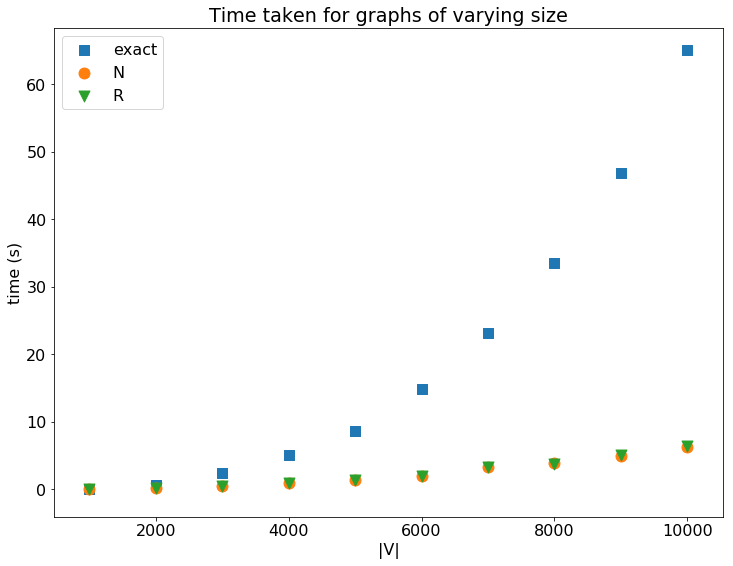

In [471]:
show_scatter(matrix_sizes, size_times, "Time taken for graphs of varying size", "|V|", "time (s)")

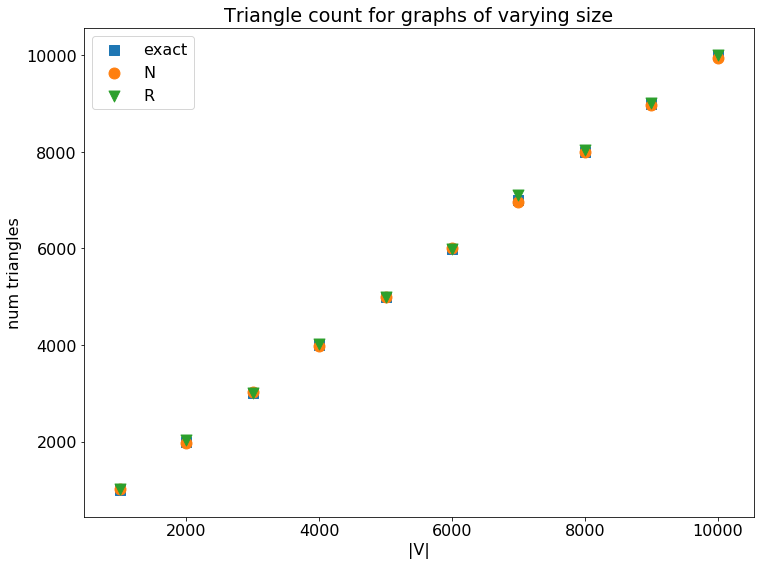

In [472]:
show_scatter(matrix_sizes, size_averages, "Triangle count for graphs of varying size", "|V|", "num triangles")

In [517]:
if rerun:
    gammas = list(range(1,11))
    gamma_times, gamma_variances, gamma_errors = prepare_gamma_comparison(1000, gammas)

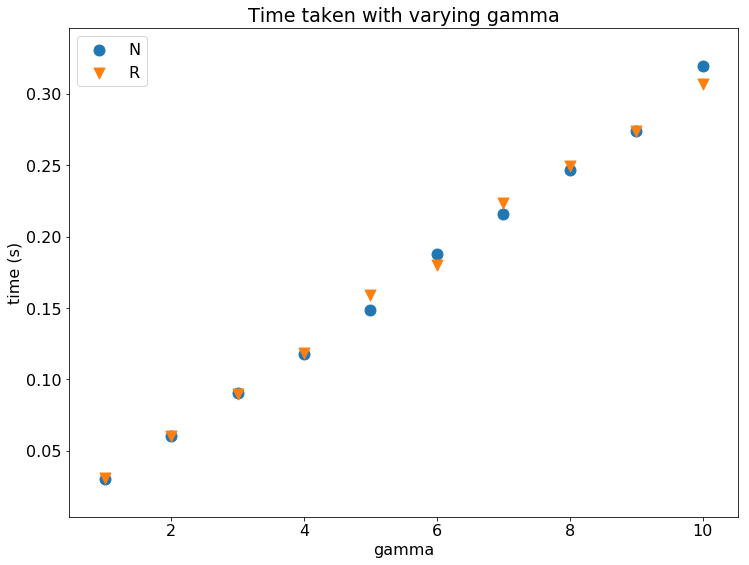

In [521]:
show_scatter(gammas, gamma_times, "Time taken with varying gamma", "gamma", "time (s)")

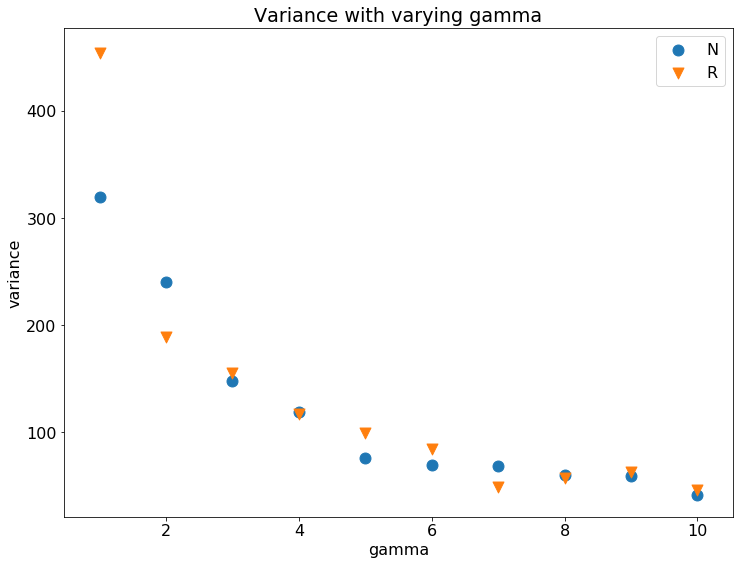

In [522]:
show_scatter(gammas, gamma_variances, "Variance with varying gamma", "gamma", "variance")

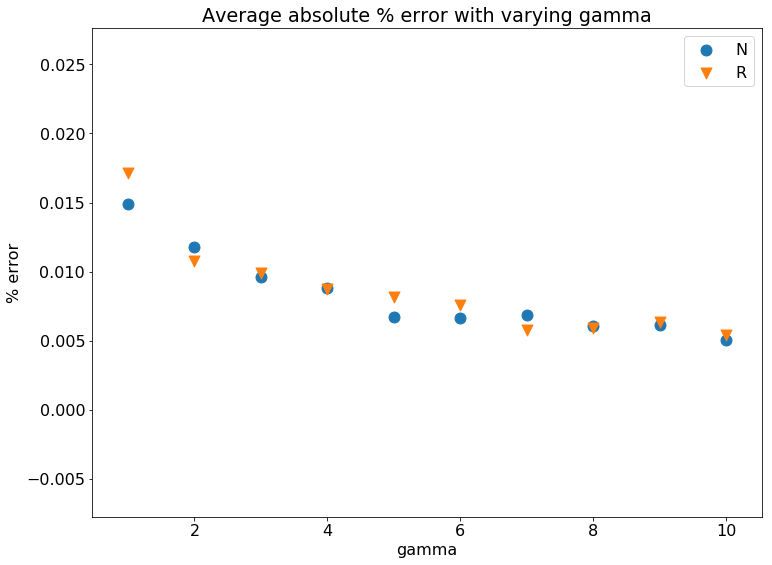

In [523]:
show_scatter(gammas, gamma_errors, "Average absolute % error with varying gamma", "gamma", "% error")

In [484]:
if rerun:
    tri_counts = [int(math.pow(2, x/2)) for x in range(40)]
    sparse_averages, sparse_variances, sparse_errors = prepare_sparse_comparison(100, tri_counts, False, gamma=1)

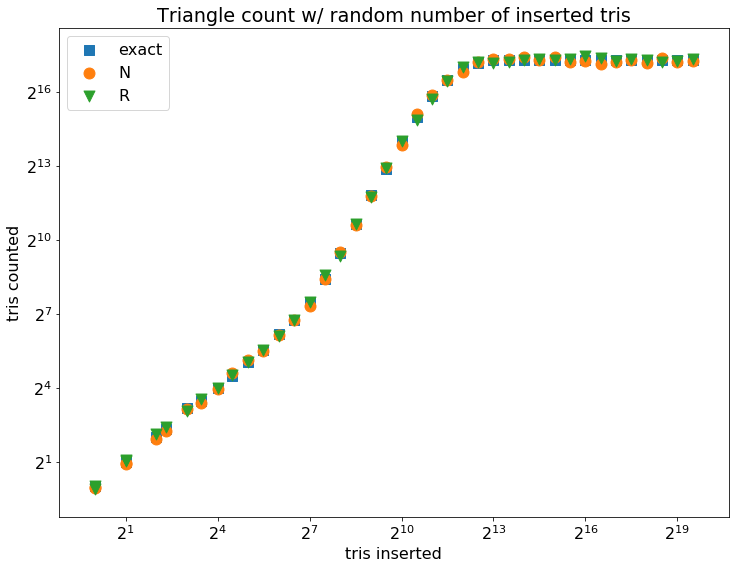

In [485]:
show_scatter(tri_counts, sparse_averages, "Triangle count w/ random number of inserted tris", "tris inserted", "tris counted", mode="loglog")

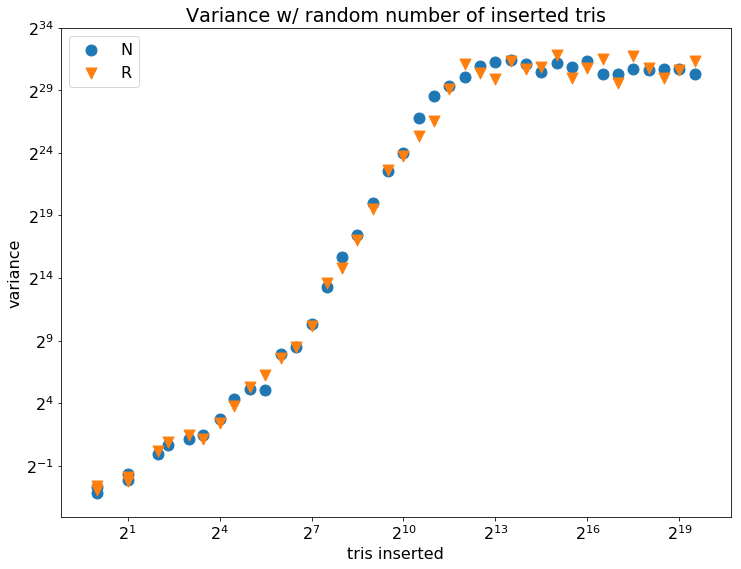

In [525]:
show_scatter(tri_counts, sparse_variances, "Variance w/ random number of inserted tris", "tris inserted", "variance", mode="loglog", ignore_exact=True)

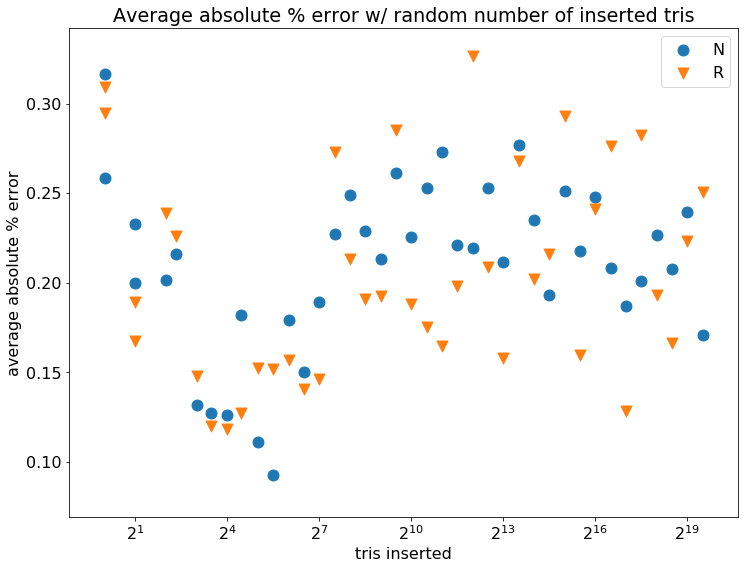

In [524]:
show_scatter(tri_counts, sparse_errors, "Average absolute % error w/ random number of inserted tris", "tris inserted", "average absolute % error", mode="log", ignore_exact=True)

In [244]:
ExactTriangles(generate_random(1000, 1, True))

166663671

In [245]:
dense_averages

{'N': [170286832.44999999,
  164572044.55888885,
  156929197.09111109,
  167483894.35444441,
  171146949.82111114,
  159409672.64555559,
  168479871.69999999,
  171900547.38777778,
  166957684.58722222,
  160198342.62499997],
 'R': [169714615.89888892,
  172164993.94222218,
  176668664.08333337,
  173471680.34666663,
  154092382.19555557,
  170453176.91444442,
  173993572.92666665,
  165897530.52777776,
  164783154.49277773,
  159650482.84722224]}

In [366]:
prepare_sparse_comparison(11, [25], False, 1000)

({'N': [58.717987246377078], 'R': [58.777971014493005], 'exact': [84.0]},
 {'N': [1.2730480926917778], 'R': [1.4540043818694193], 'exact': [0.0]},
 {'N': [0.30097634230503501], 'R': [0.3002622498274643], 'exact': [0.0]})

In [349]:
TraceTriangleN(A10, 1000)

8.0560794668678302

In [423]:
x =generate_random(20, 25)

In [429]:
TraceTriangleN(x, 1)

77.777777777777771

In [425]:
ExactTriangles(x)

48

In [426]:
x

array([[ 0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         1.,  0.,  1.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  1.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,
         1.,  1.,  1.,  0.,  1.,  0.,  1.],
       [ 0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,
         1.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,
         0.,  0.,  0.,  1.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  

In [440]:
gamma_errors

{}

In [444]:
int(math.pow(2,3.2))

9

In [495]:
prepare_gamma_comparison(100, [1, 2, 3])

({'N': [0.000759735107421875, 0.0013603401184082032, 0.0020004558563232423],
  'R': [0.0006401443481445313, 0.0013602733612060546, 0.0019611167907714845]},
 {'N': [67.338014325068784, 39.00181998677968, 16.479882638888867],
  'R': [126.16644407713497, 26.954973955892079, 28.112511458333373]},
 {'N': [0.069771181199752605, 0.050378104730264203, 0.031653911564625908],
  'R': [0.097489177489177473, 0.046144597373833293, 0.044315476190476211]})

In [23]:
np.linalg.eig(generate_random(250, 10000000))

(array([ -1.+0.00000000e+00j, 249.+0.00000000e+00j,  -1.+0.00000000e+00j,
         -1.+0.00000000e+00j,  -1.+0.00000000e+00j,  -1.+5.76541500e-15j,
         -1.-5.76541500e-15j,  -1.+0.00000000e+00j,  -1.+0.00000000e+00j,
         -1.+1.85775845e-15j,  -1.-1.85775845e-15j,  -1.+3.33621557e-15j,
         -1.-3.33621557e-15j,  -1.+0.00000000e+00j,  -1.+0.00000000e+00j,
         -1.+8.43696455e-16j,  -1.-8.43696455e-16j,  -1.+0.00000000e+00j,
         -1.+0.00000000e+00j,  -1.+0.00000000e+00j,  -1.+0.00000000e+00j,
         -1.+0.00000000e+00j,  -1.+0.00000000e+00j,  -1.+0.00000000e+00j,
         -1.+0.00000000e+00j,  -1.+0.00000000e+00j,  -1.+0.00000000e+00j,
         -1.+0.00000000e+00j,  -1.+0.00000000e+00j,  -1.+0.00000000e+00j,
         -1.+0.00000000e+00j,  -1.+0.00000000e+00j,  -1.+0.00000000e+00j,
         -1.+0.00000000e+00j,  -1.+0.00000000e+00j,  -1.+0.00000000e+00j,
         -1.+0.00000000e+00j,  -1.+0.00000000e+00j,  -1.+0.00000000e+00j,
         -1.+0.00000000e+00j,  -1.+0.0